In [15]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO1d
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import LpLoss_energy

device = 'cpu'

In [16]:
# Subsampling rate
sampling_rate = 3
ntrain = 1000
ntest = 100
batch_size = 32

t1 = 5
t2 = 7


In [17]:
data = np.load("data/ks_1d_data.npy").astype(np.float32)
grid_range = 1

x_data = torch.tensor(data[:,t1])
y_data = torch.tensor(data[:,t2])
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
size_x = x_data.shape[1]

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain], y_data[:ntrain]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
gridx = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
gridx = gridx.reshape(1, 1, size_x)

x_train = torch.cat((x_train, gridx.repeat([ntrain, 1, 1])), dim=1)
x_test = torch.cat((x_test, gridx.repeat([ntest, 1, 1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

In [18]:
model = TFNO1d(n_modes_height=(16), hidden_channels=32, projection_channels=64,
             in_channels = 2, factorization='tucker', rank=0.42, use_mlp = True, mlp_dropout = 0.8)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 52161 parameters.


In [19]:
l2loss = LpLoss(d=2, p=2)

eval_losses={'l2': l2loss}

# Training parameters
epochs = 20
learning_rate = 0.005
step_size = 50   # weight-decay step size
gamma = 0.5      # weight-decay rate

optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [20]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-1.8160, Train-MSE-1.0013, Train-L2-0.0320, Test-L2-0.0400
Epoch-1, Time-1.8223, Train-MSE-1.0022, Train-L2-0.0320, Test-L2-0.0400
Epoch-2, Time-1.5843, Train-MSE-1.0002, Train-L2-0.0320, Test-L2-0.0400
Epoch-3, Time-1.9161, Train-MSE-0.9965, Train-L2-0.0319, Test-L2-0.0400
Epoch-4, Time-1.4895, Train-MSE-0.9966, Train-L2-0.0319, Test-L2-0.0399
Epoch-5, Time-1.4593, Train-MSE-0.9982, Train-L2-0.0319, Test-L2-0.0399
Epoch-6, Time-2.0690, Train-MSE-0.9990, Train-L2-0.0319, Test-L2-0.0399
Epoch-7, Time-1.4933, Train-MSE-1.0031, Train-L2-0.0320, Test-L2-0.0400
Epoch-8, Time-1.0170, Train-MSE-0.9970, Train-L2-0.0319, Test-L2-0.0400
Epoch-9, Time-0.8546, Train-MSE-0.9971, Train-L2-0.0319, Test-L2-0.0399
Epoch-10, Time-0.8580, Train-MSE-0.9978, Train-L2-0.0319, Test-L2-0.0399
Epoch-11, Time-0.9149, Train-MSE-0.9929, Train-L2-0.0319, Test-L2-0.0399
Epoch-12, Time-0.9191, Train-MSE-0.9954, Train-L2-0.0319, Test-L2-0.0400
Epoch-13, Time-1.0790, Train-MSE-0.9920, Train-L2-0.0319, Tes

In [21]:
# %%
""" Prediction """
pred = []
test_e = []
with torch.no_grad():
    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y= sample["y"].to(device)
        test_l2 = 0 

        out = model(x)
        test_l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        test_e.append( test_l2/batch_size )
        pred.append( out )
        print("Batch-{}, Test-loss-{:0.6f}".format( index, test_l2/batch_size ))
        index += 1

pred = torch.cat((pred))
test_e = torch.tensor((test_e))  
print('Mean Error:', 100*torch.mean(test_e).numpy())

Batch-0, Test-loss-0.031108
Batch-1, Test-loss-0.031197
Batch-2, Test-loss-0.031233
Batch-3, Test-loss-0.030931
Mean Error: 3.111731633543968


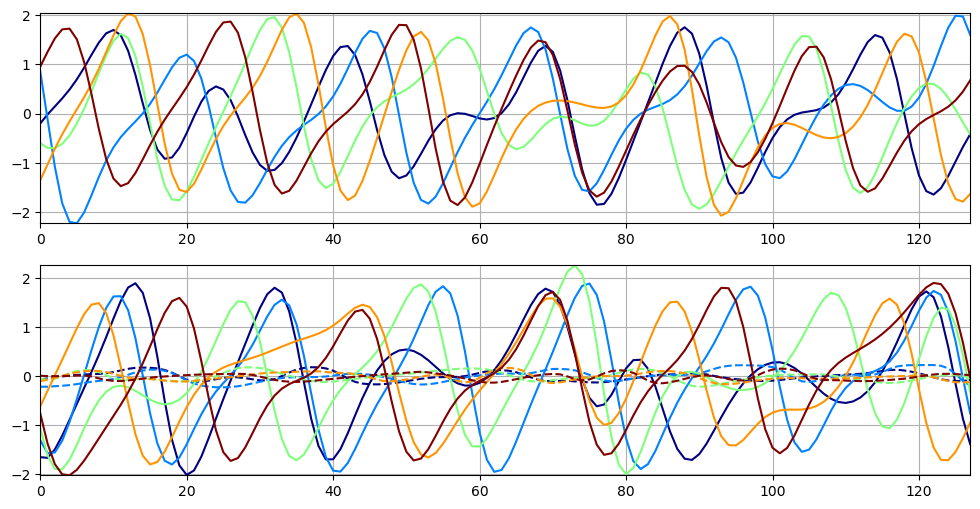

In [22]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 20 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

# PFNO

In [23]:
class WrapGenMultipleSimulations(nn.Module):
    """"""

    def __init__(self, net: nn.Module, n_samples: int = 3):
        """
        Args:
            net (nn.Module): net to wrap
            n_samples (int): number of simulations from the generator per parameter value. Default
                                is 3.
        """
        super(WrapGenMultipleSimulations, self).__init__()
        self.net = net
        self.n_samples = n_samples

    def forward(self, _input, n_samples: int = None):
        """
        Forward pass through the network self.n_samples times

        Args:
            _input: torch Tensor input to the network

        Returns:
            Outputs of the network, stacked along the second dimension and adding a last dimension if missing.
            Shape is therefore [batch, n_samples, out_size].
        """

        if n_samples is None:
            n_samples = self.n_samples

        outputs = [self.net(_input) for i in range(n_samples)]

        # stack along the second dimension and add a last dimension if missing.
        return torch.atleast_3d(torch.stack(outputs, dim=-1))

In [24]:
model = TFNO1d(n_modes_height=(16), hidden_channels=32, projection_channels=64,
             in_channels = 2, factorization='tucker', rank=0.42, use_mlp = True, mlp_dropout = 0.8)
sample_model = WrapGenMultipleSimulations(model, n_samples=10).to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
# Loss function
energy_score = LpLoss_energy()

In [25]:
# Training parameters
epochs = 20
learning_rate = 0.005
step_size = 50   # weight-decay step size
gamma = 0.5      # weight-decay rate

optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [26]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-17.3128, Train-L2-0.0592, Test-L2-0.0713
Epoch-1, Time-14.7263, Train-L2-0.0564, Test-L2-0.0711
Epoch-2, Time-15.8268, Train-L2-0.0563, Test-L2-0.0708
Epoch-3, Time-17.3129, Train-L2-0.0561, Test-L2-0.0710
Epoch-4, Time-16.6564, Train-L2-0.0560, Test-L2-0.0709
Epoch-5, Time-17.7316, Train-L2-0.0559, Test-L2-0.0704
Epoch-6, Time-14.7904, Train-L2-0.0557, Test-L2-0.0695
Epoch-7, Time-14.6574, Train-L2-0.0554, Test-L2-0.0693
Epoch-8, Time-16.0939, Train-L2-0.0552, Test-L2-0.0688
Epoch-9, Time-15.2215, Train-L2-0.0551, Test-L2-0.0691
Epoch-10, Time-11.0166, Train-L2-0.0553, Test-L2-0.0695
Epoch-11, Time-15.0273, Train-L2-0.0552, Test-L2-0.0692
Epoch-12, Time-19.2879, Train-L2-0.0546, Test-L2-0.0687
Epoch-13, Time-15.6177, Train-L2-0.0547, Test-L2-0.0701
Epoch-14, Time-14.8119, Train-L2-0.0543, Test-L2-0.0681
Epoch-15, Time-14.4869, Train-L2-0.0540, Test-L2-0.0687
Epoch-16, Time-13.2205, Train-L2-0.0538, Test-L2-0.0671
Epoch-17, Time-11.8443, Train-L2-0.0541, Test-L2-0.0680
Ep

In [27]:
# %%
""" Prediction """
pred = []
test_e = []
with torch.no_grad():
    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y= sample["y"].to(device)
        test_l2 = 0 

        out = sample_model(x, n_samples = 100)
        test_l2 = energy_score(out,y)

        test_e.append( test_l2/batch_size )
        pred.append( out )
        print("Batch-{}, Test-loss-{:0.6f}".format( index, test_l2/batch_size ))
        index += 1

pred = torch.cat((pred))
test_e = torch.tensor((test_e))  
print('Mean Error:', 100*torch.mean(test_e).numpy())

Batch-0, Test-loss-0.052575
Batch-1, Test-loss-0.053323
Batch-2, Test-loss-0.054635
Batch-3, Test-loss-0.051373
Mean Error: 5.297671630978584


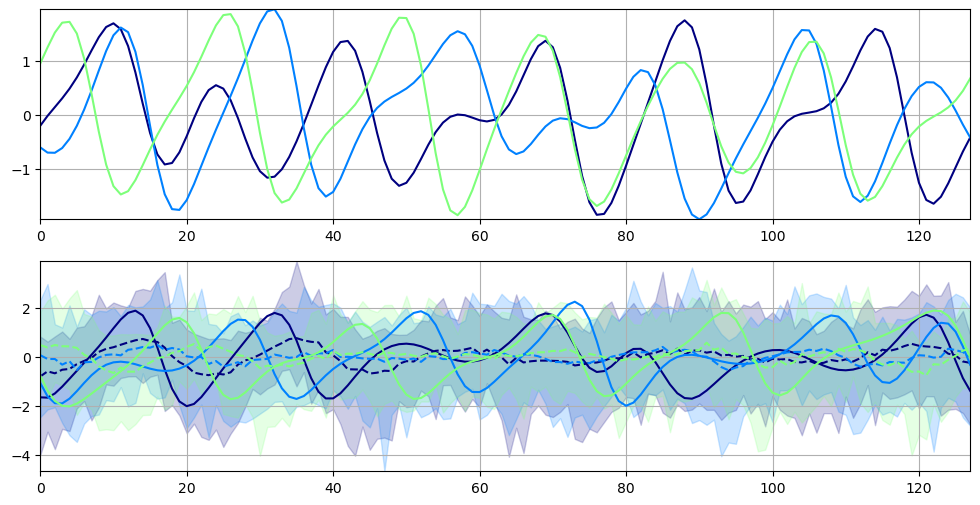

In [38]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)